In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


# 1. import and Load data

In [7]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

In [8]:
train = pd.read_table("/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip")
test = pd.read_table("/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip")
sub = pd.read_csv("/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv")

In [9]:
sub

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


In [10]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [11]:
test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


# 2. Function

In [12]:
def graph(history):
    '''
    train, valid set 으로 모델이 학습한 acc, val_acc, loss, val_loss 를 에포크에 따라 추이를 파악해보는 함수.
    몇 번째 학습에서 과적합이 되는지, 혹은 학습이 잘 되고 있는지 확인.
    '''
    plt.style.use('default')
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(9,4))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'b', label = f'Training acc : {acc[-1]:.3f}')
    plt.plot(epochs, val_acc, 'r', label = f'Validation acc : {val_acc[-1]:.3f}')
    plt.title('Training and Validation acc')
    plt.xlabel(f'total epochs : {len(acc)}')
    plt.ylabel('acc score')
    plt.legend(loc='best')
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'b', label = f'Training loss : {loss[-1]:.3f}')
    plt.plot(epochs, val_loss, 'r', label = f'Validation loss : {val_loss[-1]:.3f}')
    plt.title('Training and Validation loss')
    plt.xlabel(f'total epochs : {len(loss)}')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show();

In [13]:
def load_embedding(path):
    '''
    pretrained embedding 을 불러오는 함수
    '''
    embeddings = {}
    with open(path) as f:
        for i in f:
            value = i.rstrip().split()
            embeddings[value[0]] = np.asarray(value[1:], dtype='float32')
    return embeddings

In [14]:
def filter_embedding(embeddings, word_index, vocab_size, dim=300):
    '''
    불러온 pretrained embedding 과 현재 데이터에서 학습한 token 사이에 일치하는 단어만 추출하는 filtering 함수
    '''
    embedding_matrix = np.zeros((vocab_size, dim))
    for word, i in word_index.items():
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

# 3. Description


### Dataset

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

* `train.tsv` contains the phrases and their associated sentiment labels. 
    We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.  
* `test.tsv` contains just phrases. You must assign a sentiment label to each phrase.  

# Metrics

Submissions are evaluated on `classification accuracy` (the percent of labels that are predicted correctly) for every parsed phrase.   
The sentiment labels are:  

0 - negative  
1 - somewhat negative  
2 - neutral  
3 - somewhat positive  
4 - positive  



# 4. EDA

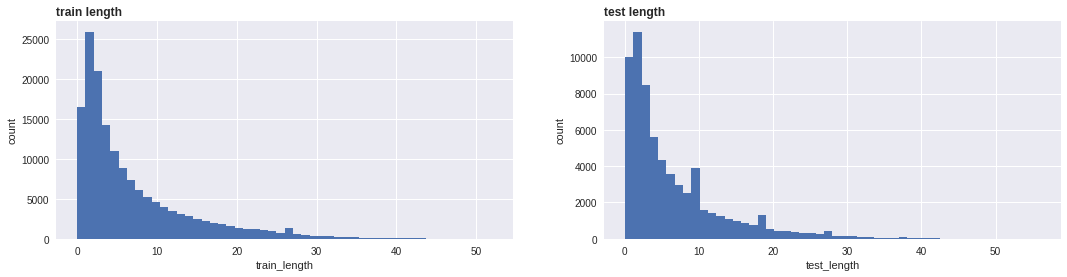

In [15]:
# Phrase length
train_eda = train.copy()
test_eda = test.copy()
train_eda['length'] = train_eda['Phrase'].apply(lambda x: len(x.split()))
test_eda['length'] = test_eda['Phrase'].apply(lambda x: len(x.split()))

plt.style.use('seaborn')
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.hist(train_eda['length'], bins=50)
plt.xlabel('train_length')
plt.ylabel('count')
plt.title('train length', 
          fontweight='bold', 
          loc='left')

plt.subplot(122)
plt.hist(test_eda['length'], bins=50)
plt.xlabel('test_length')
plt.ylabel('count')
plt.title('test length', 
          fontweight='bold', 
          loc='left')

plt.show();

In [16]:
len(train), len(test)

(156060, 66292)

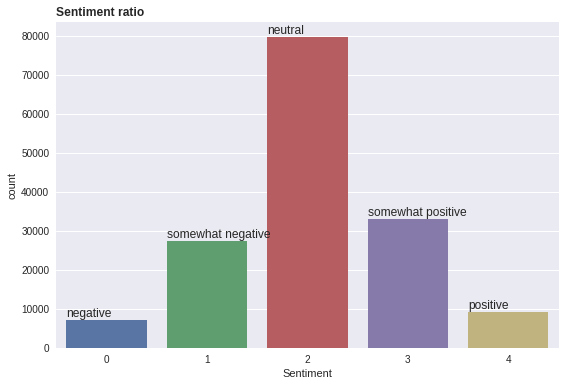

In [17]:
plt.figure(figsize=(9,6))
sns.countplot(train['Sentiment']);
plt.title("Sentiment ratio", fontweight='bold', loc='left')
text = ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']
for x in range(5):
    plt.text(x-0.4, len(train[train['Sentiment']==x])+1000, text[x], fontsize=12)
plt.show();

In [18]:
train_eda.groupby('Sentiment')['length'].agg(['min','median','mean','std','max','count'])

,min,median,mean,std,max,count
Sentiment,,,,,,
0,1,10,12.105345,8.755793,52,7072
1,0,7,9.112016,7.609619,51,27273
2,1,3,5.194617,5.348528,51,79582
3,1,6,8.446594,7.566081,51,32927
4,1,8,10.701390,8.493600,52,9206


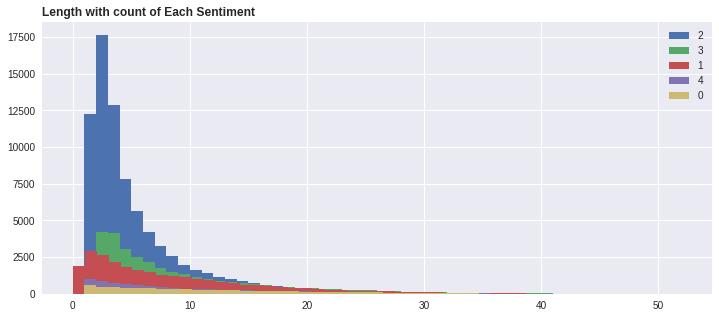

In [19]:
_bins = 50
plt.figure(figsize=(12,5))
for i in [2,3,1,4,0]:
    plt.hist(train_eda[train_eda['Sentiment']==i].loc[:,'length'], bins=_bins, label=f'{i}');
plt.legend(loc='upper right')
plt.title("Length with count of Each Sentiment", fontweight='bold', loc='left')
plt.show();

In [20]:
for i in range(30):
    print(f'index {i*4000} : ',train['Phrase'].loc[i*4000], end='\n\n')

index 0 :  A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

index 4000 :  America

index 8000 :  a better celebration of these unfairly

index 12000 :  with its own cuteness

index 16000 :  exotic dancing

index 20000 :  solid piece

index 24000 :  as an exceptional thriller

index 28000 :  Chelsea Walls is a case of too many chefs fussing over too weak a recipe .

index 32000 :  has considerable charm .

index 36000 :  Newcastle

index 40000 :  dark and stormy

index 44000 :  uneasy bonds

index 48000 :  frantic than involving , more chaotic than entertaining

index 52000 :  seen ` jackass : the movie

index 56000 :  The high-concept scenario soon proves preposterous , the acting is robotically italicized , and

index 60000 :  accomplishes in his chilling , unnerving film

index 64000 :  infinitely

index 68000 :  husband-and-wife

index 72000 : 

* 중립성의 글이 가장 많고, 긍정 부정 쪽으로는 거의 균등한 분포를 보인다.  
* train set 의 글의 길이와 test set 의 글의 길이는 전반적으로 비슷한 분포를 보인다.  
* 실제 글은, 단어 하나로 끝나는 경우도 있고, 어느정도 글의 구성을 갖춘 글도 있다.  

# 5. Preprocessing text

In [21]:
allData = pd.concat([train, test])

In [22]:
# Tokenzier 를 사용한 텍스트 토큰화
tk = Tokenizer(lower=True)
tk.fit_on_texts(allData['Phrase'])
len(tk.word_index)

17780

In [23]:
# Tokenzier 로 텍스트를 토큰화
all_text = tk.texts_to_sequences(allData['Phrase'])
# all_text

In [24]:
# pad_sequences 로 모두 같은 길이로 패딩시킨다.
# 앞쪽에 패딩을 준다. 일반적으로 RNN계열은 최근 데이터(뒤쪽 데이터)를 마지막으로 학습하여 가중치 할당이 높게 되기 때문.
all_pad = pad_sequences(all_text, maxlen=None, padding='pre')
all_pad

array([[   0,    0,    0, ...,    3,    2,   42],
       [   0,    0,    0, ...,   13,    1, 3940],
       [   0,    0,    0, ...,    0,    2,  315],
       ...,
       [   0,    0,    0, ...,    2,  118, 4456],
       [   0,    0,    0, ...,    2,  118, 4456],
       [   0,    0,    0, ...,    0,  343, 1623]], dtype=int32)

In [25]:
all_pad.shape

(222352, 52)

In [26]:
train_pad = all_pad[:len(train)]
test_pad = all_pad[len(train):]
train_pad.shape, test_pad.shape

((156060, 52), (66292, 52))

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(train_pad,
                                                      train['Sentiment'],
                                                      test_size=0.2,
                                                      stratify=train['Sentiment'],
                                                      random_state=9)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((124848, 52), (31212, 52), (124848,), (31212,))

# 6. Modeling

1. text 및 sequence 학습에 좋은 RNN 계열(SimpleRNN, LSTM, GRU)로 텍스트 학습을 해볼 것이다.  

2. 2가지 방법으로 학습해본다.  

    1) `Embedding 층 + LSTM 으로 설계` : LSTM 의 경우 return_sequences 옵션을 주어 앞의 내용을 더 잘 기억할 수 있도록 해준다.    
    2) `Pretrained Embedding` : Embedding 에 미리 학습된 embedding 단어 및 가중치 행렬을 불러와 학습시킨다.    
        : GloVe, Word2Vec, fasttext 등이 있지만, facebook 에서 추출한 단어로 학습된 fasttext로 학습시켜볼 것이다.    


3. StratifyKFold  

    앞선 방법으로 층을 설계 했지만, validation data 를 위해서 train_test_split 를 사용하게 되면    
    validation_data 에 해당하는 데이터는 train data set으로 학습하지 못한다는 단점이 존재한다.   
    scikit-learn 의 StratifyKFold 를 사용하여 전체 데이터를 모두 균등하게 학습시켜 예측하는데 활용해보자.    

## 6-1) 기본 Embeeding 층 + LSTM 층 실험

In [33]:
model = Sequential()

model.add(Embedding(len(tk.word_index)+1, 128, input_length=train_pad.shape[1]))
model.add(LSTM(64, return_sequences=True)) # return_sequences = True 옵션을 준다. 전체 시퀀스에 대한 결과값이 추출된다.
model.add(LSTM(64, return_sequences=False)) # return_sequenes = False : 이 이후에 Flatten 층을 주지 않아도 된다. 마지막 결과값만 추출된다.
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 52, 128)           2275968   
_________________________________________________________________
lstm_4 (LSTM)                (None, 52, 64)            49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 2,360,645
Trainable params: 2,360,645
Non-trainable params: 0
____________________________________________

In [34]:
es = EarlyStopping(patience=3, 
                   monitor='val_loss',
                   verbose=1)

mc = ModelCheckpoint('best.h5',
                     monitor='val_loss',
                     save_best_only=True, 
                     verbose=1)

rp = ReduceLROnPlateau(patience=2, 
                       verbose=1, 
                       monitor='val_loss',
                       min_lr=0.0001,
                       factor=0.5)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(1e-3),
              metrics=['acc'])

In [35]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[es,mc,rp])

Epoch 1/10
3901/3902 [============================>.] - ETA: 0s - loss: 0.9659 - acc: 0.6097
Epoch 00001: val_loss improved from inf to 0.84030, saving model to best.h5
3902/3902 [==============================] - 111s 28ms/step - loss: 0.9659 - acc: 0.6097 - val_loss: 0.8403 - val_acc: 0.6522
Epoch 2/10
3902/3902 [==============================] - ETA: 0s - loss: 0.7673 - acc: 0.6849
Epoch 00002: val_loss improved from 0.84030 to 0.79486, saving model to best.h5
3902/3902 [==============================] - 110s 28ms/step - loss: 0.7673 - acc: 0.6849 - val_loss: 0.7949 - val_acc: 0.6697
Epoch 3/10
3901/3902 [============================>.] - ETA: 0s - loss: 0.6853 - acc: 0.7152
Epoch 00003: val_loss improved from 0.79486 to 0.79195, saving model to best.h5
3902/3902 [==============================] - 109s 28ms/step - loss: 0.6853 - acc: 0.7152 - val_loss: 0.7919 - val_acc: 0.6766
Epoch 4/10
3901/3902 [============================>.] - ETA: 0s - loss: 0.6255 - acc: 0.7376
Epoch 00004: v

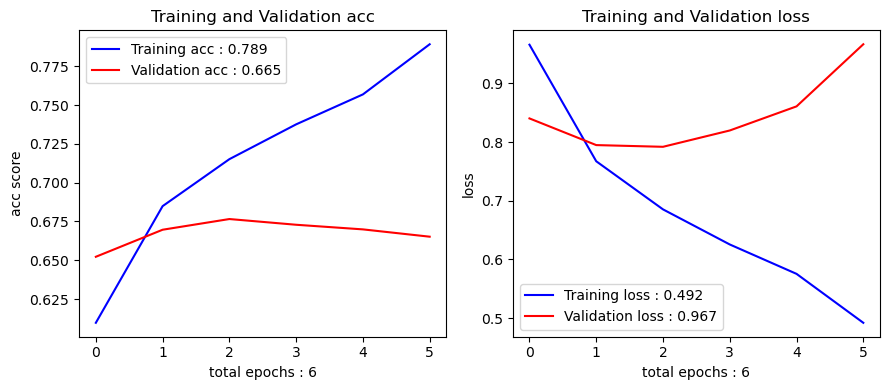

In [36]:
graph(history)

In [41]:
model.load_weights('best.h5')
result_base = model.predict(test_pad)
result_base

array([[3.40407738e-03, 1.13994844e-01, 5.19769728e-01, 3.49973857e-01,
        1.28574604e-02],
       [3.40407738e-03, 1.13994844e-01, 5.19769728e-01, 3.49973857e-01,
        1.28574604e-02],
       [8.18975241e-05, 1.68779306e-02, 8.67257118e-01, 1.14969075e-01,
        8.13956140e-04],
       ...,
       [2.18717870e-03, 2.10046232e-01, 7.73983777e-01, 1.37444502e-02,
        3.83695260e-05],
       [2.18717870e-03, 2.10046232e-01, 7.73983777e-01, 1.37444502e-02,
        3.83695260e-05],
       [4.42384603e-03, 3.28134090e-01, 6.49645984e-01, 1.77440532e-02,
        5.20464637e-05]], dtype=float32)

In [43]:
sub['Sentiment'] = result_base.argmax(1)
sub

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,1
66288,222349,1
66289,222350,2
66290,222351,2


In [44]:
sub.to_csv("base_model.csv", index=0)

* score : 0.64653
* rank : 145/860

## 6-2) Pretrained embedding : fasttext embedding

사전 학습된 임베딩 추가하여 학습하기 : facebook 기반, 300차원의 임베딩  
비교를 위해 옵션은 같은 상태에서 학습시켜본다.  
https://www.kaggle.com/yekenot/fasttext-crawl-300d-2m

In [45]:
# pretrained Embedding 추가하기
path = "../input/fasttext/crawl-300d-2M.vec"
embeddings = load_embedding(path)

In [46]:
# pretrained embedding 과 현재 데이터의 Tokenizer 사이에 둘 다 존재하는 단어의 임베딩만 추출하기
embedding_matrix = filter_embedding(embeddings, tk.word_index, len(tk.word_index)+1, 300)
embedding_matrix.shape

(17781, 300)

In [51]:
model = Sequential()

model.add(Embedding(len(tk.word_index)+1, 
                    300, 
                    input_length=train_pad.shape[1],
                    weights=[embedding_matrix], # 사전 학습된 embedding 활용
                    trainable=False)) # 사전 학습된 embedding 이 변하지 않고 그대로 학습에 이용할 수 있도록 옵션 설정

model.add(LSTM(64, return_sequences=True)) # return_sequences = True 옵션을 준다. 전체 시퀀스에 대한 결과값이 추출된다.
model.add(LSTM(64, return_sequences=False)) # return_sequenes = False : 이 이후에 Flatten 층을 주지 않아도 된다. 마지막 결과값만 추출된다.
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 52, 300)           5334300   
_________________________________________________________________
lstm_8 (LSTM)                (None, 52, 64)            93440     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 5,463,009
Trainable params: 128,709
Non-trainable params: 5,334,300
______________________________________

In [52]:
es = EarlyStopping(patience=5, 
                   monitor='val_loss',
                   verbose=1)

mc = ModelCheckpoint('best.h5',
                     monitor='val_loss',
                     save_best_only=True, 
                     verbose=1)

rp = ReduceLROnPlateau(patience=3, 
                       verbose=1, 
                       monitor='val_loss',
                       min_lr=0.0001,
                       factor=0.5)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(1e-3),
              metrics=['acc'])

In [53]:
history2 = model.fit(X_train, y_train,
                     epochs=20,
                     batch_size=32,
                     validation_data=(X_valid, y_valid),
                     callbacks=[es,mc,rp])

Epoch 1/20
3900/3902 [============================>.] - ETA: 0s - loss: 0.9005 - acc: 0.6267
Epoch 00001: val_loss improved from inf to 0.83724, saving model to best.h5
3902/3902 [==============================] - 36s 9ms/step - loss: 0.9005 - acc: 0.6267 - val_loss: 0.8372 - val_acc: 0.6472
Epoch 2/20
3898/3902 [============================>.] - ETA: 0s - loss: 0.8073 - acc: 0.6641
Epoch 00002: val_loss improved from 0.83724 to 0.80301, saving model to best.h5
3902/3902 [==============================] - 34s 9ms/step - loss: 0.8072 - acc: 0.6641 - val_loss: 0.8030 - val_acc: 0.6662
Epoch 3/20
3901/3902 [============================>.] - ETA: 0s - loss: 0.7513 - acc: 0.6869
Epoch 00003: val_loss improved from 0.80301 to 0.78499, saving model to best.h5
3902/3902 [==============================] - 35s 9ms/step - loss: 0.7513 - acc: 0.6869 - val_loss: 0.7850 - val_acc: 0.6737
Epoch 4/20
3902/3902 [==============================] - ETA: 0s - loss: 0.7118 - acc: 0.7029
Epoch 00004: val_los

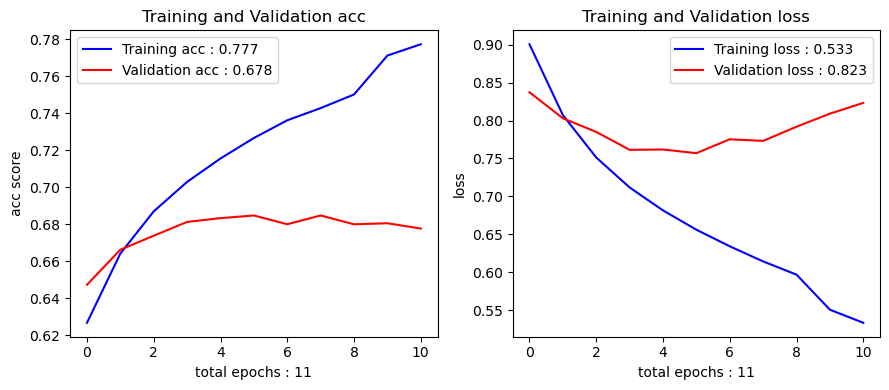

In [54]:
graph(history2)

In [55]:
model.load_weights('best.h5')
result_embedding = model.predict(test_pad)
result_embedding

array([[2.5253481e-05, 1.2569647e-02, 3.7208283e-01, 6.0367900e-01,
        1.1643309e-02],
       [2.5253481e-05, 1.2569647e-02, 3.7208283e-01, 6.0367900e-01,
        1.1643309e-02],
       [1.9552121e-04, 2.4161020e-02, 8.4764469e-01, 1.2593743e-01,
        2.0613445e-03],
       ...,
       [3.7300037e-03, 3.8795561e-01, 5.9615809e-01, 1.2145275e-02,
        1.0985658e-05],
       [3.7300037e-03, 3.8795561e-01, 5.9615809e-01, 1.2145275e-02,
        1.0985658e-05],
       [1.5628822e-02, 5.8187187e-01, 3.9697179e-01, 5.5225757e-03,
        4.9905752e-06]], dtype=float32)

In [56]:
sub['Sentiment'] = result_embedding.argmax(1)
sub

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
...,...,...
66287,222348,1
66288,222349,1
66289,222350,2
66290,222351,2


In [57]:
sub.to_csv("pretrained.csv", index=0)

* Base model  
    score : 0.64653  
    rank : 145/860  

* Pretrained model  
    score : 0.66383  
    rank : 26/860  
        
* 사전 임베딩 모델을 사용하게 되면 더욱 학습이 잘 되는 것을 확인할 수 있다.

## 6-3) StratifyKFold 학습으로 모든 데이터를 학습시키고 앙상블 효과를 주자.

In [59]:
%%time

X = train_pad
y = train['Sentiment']

skf = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)

result_skf = 0

for train_index, valid_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_valid, y_valid = X[valid_index], y[valid_index]
    
    model = Sequential()

    model.add(Embedding(len(tk.word_index)+1, 
                        300, 
                        input_length=train_pad.shape[1],
                        weights=[embedding_matrix], # 사전 학습된 embedding 활용
                        trainable=False)) # 사전 학습된 embedding 이 변하지 않고 그대로 학습에 이용할 수 있도록 옵션 설정

    model.add(LSTM(64, return_sequences=True)) # return_sequences = True 옵션을 준다. 전체 시퀀스에 대한 결과값이 추출된다.
    model.add(LSTM(64, return_sequences=False)) # return_sequenes = False : 이 이후에 Flatten 층을 주지 않아도 된다. 마지막 결과값만 추출된다.
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))
    model.summary()

    es = EarlyStopping(patience=5, 
                   monitor='val_loss',
                   verbose=1)

    mc = ModelCheckpoint('best.h5',
                         monitor='val_loss',
                         save_best_only=True, 
                         verbose=1)

    rp = ReduceLROnPlateau(patience=3, 
                           verbose=1, 
                           monitor='val_loss',
                           min_lr=0.0001,
                           factor=0.5)

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(1e-3),
                  metrics=['acc'])



    model.fit(X_train, y_train,
              epochs=20,
              batch_size=32,
              validation_data=(X_valid, y_valid),
              callbacks=[es,mc,rp])
    
    model.load_weights('best.h5')
    result_skf += model.predict(test_pad)/5
    
print('done')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 52, 300)           5334300   
_________________________________________________________________
lstm_10 (LSTM)               (None, 52, 64)            93440     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 165       
Total params: 5,463,009
Trainable params: 128,709
Non-trainable params: 5,334,300
______________________________________

3901/3902 [============================>.] - ETA: 0s - loss: 0.9031 - acc: 0.6248
Epoch 00001: val_loss improved from inf to 0.83173, saving model to best.h5
3902/3902 [==============================] - 35s 9ms/step - loss: 0.9032 - acc: 0.6248 - val_loss: 0.8317 - val_acc: 0.6549
Epoch 2/20
3896/3902 [============================>.] - ETA: 0s - loss: 0.8081 - acc: 0.6629
Epoch 00002: val_loss improved from 0.83173 to 0.78918, saving model to best.h5
3902/3902 [==============================] - 35s 9ms/step - loss: 0.8080 - acc: 0.6629 - val_loss: 0.7892 - val_acc: 0.6705
Epoch 3/20
3897/3902 [============================>.] - ETA: 0s - loss: 0.7542 - acc: 0.6856
Epoch 00003: val_loss improved from 0.78918 to 0.76054, saving model to best.h5
3902/3902 [==============================] - 34s 9ms/step - loss: 0.7542 - acc: 0.6856 - val_loss: 0.7605 - val_acc: 0.6827
Epoch 4/20
3897/3902 [============================>.] - ETA: 0s - loss: 0.7138 - acc: 0.7018
Epoch 00004: val_loss improved 

3897/3902 [============================>.] - ETA: 0s - loss: 0.9084 - acc: 0.6214
Epoch 00001: val_loss improved from inf to 0.83495, saving model to best.h5
3902/3902 [==============================] - 34s 9ms/step - loss: 0.9084 - acc: 0.6215 - val_loss: 0.8350 - val_acc: 0.6525
Epoch 2/20
3896/3902 [============================>.] - ETA: 0s - loss: 0.8142 - acc: 0.6594
Epoch 00002: val_loss improved from 0.83495 to 0.80750, saving model to best.h5
3902/3902 [==============================] - 35s 9ms/step - loss: 0.8143 - acc: 0.6595 - val_loss: 0.8075 - val_acc: 0.6625
Epoch 3/20
3901/3902 [============================>.] - ETA: 0s - loss: 0.7627 - acc: 0.6818
Epoch 00003: val_loss improved from 0.80750 to 0.77532, saving model to best.h5
3902/3902 [==============================] - 34s 9ms/step - loss: 0.7627 - acc: 0.6818 - val_loss: 0.7753 - val_acc: 0.6782
Epoch 4/20
3899/3902 [============================>.] - ETA: 0s - loss: 0.7216 - acc: 0.6979
Epoch 00004: val_loss improved 

In [60]:
result_skf

array([[2.2061855e-05, 6.9308560e-03, 3.0351841e-01, 6.7501861e-01,
        1.4510097e-02],
       [2.2061855e-05, 6.9308560e-03, 3.0351841e-01, 6.7501861e-01,
        1.4510097e-02],
       [3.2305514e-05, 1.0015539e-02, 9.1084492e-01, 7.8799076e-02,
        3.0821579e-04],
       ...,
       [7.7102184e-02, 6.1893398e-01, 2.9526350e-01, 8.6605949e-03,
        3.9718037e-05],
       [7.7102184e-02, 6.1893398e-01, 2.9526350e-01, 8.6605949e-03,
        3.9718037e-05],
       [1.2075817e-02, 6.3199419e-01, 3.5138369e-01, 4.5428006e-03,
        3.5000078e-06]], dtype=float32)

In [61]:
sub['Sentiment'] = result_skf.argmax(1)
sub

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
...,...,...
66287,222348,1
66288,222349,1
66289,222350,1
66290,222351,1


In [62]:
sub.to_csv("skf.csv", index=0)

# 7. Conclusion

|model|score|rank|
|:-:|:-:|:-:|
|Base model|0.64653|145 / 860|
|Pretrained model|0.66383|26 / 860|
|StratifyKFold training model|0.67922|8 / 260|


* 딥러닝 학습 관점에서 Pretrained embedding 이 학습률을 높여주는 것을 확인했다.    
* LSTM 과 같은 layer 는 시퀀스나 텍스트 학습에 적합하다는 것을 확인할 수 있다.    
* train, valid set 을 나눈 후 학습 및 검증하게 되면, valid set 데이터 만큼 모델이 학습하지 못한다. KFOLD 학습을 통해 모델이 데이터를 균등하게 학습할 수 있도록 해준다.  
  